In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from share import *
from utils import *
from hypOpt import consensus_based_gradient
import tikzplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

### Conventional Metropolis weighted average consensus


W= [[0.675 0.125 0.1   0.1   0.   ]
 [0.125 0.675 0.1   0.1   0.   ]
 [0.1   0.1   0.6   0.1   0.1  ]
 [0.1   0.1   0.1   0.6   0.1  ]
 [0.    0.    0.1   0.1   0.8  ]]


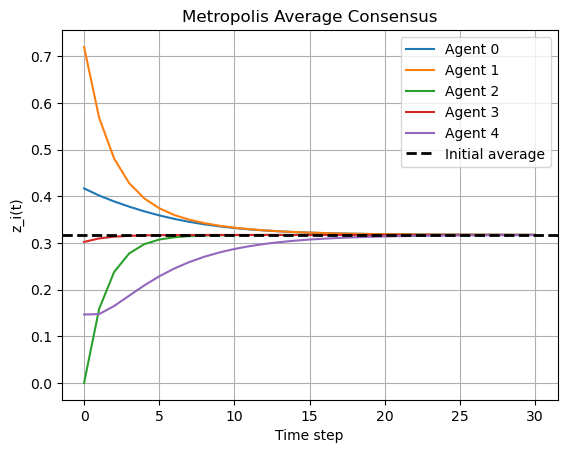

In [2]:
import networkx as nx

# Step 1: Define graph
G = nx.Graph()
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # 4-cycle
    (0, 2),  # diagonal to ensure common neighbors
    (1, 3),  # another diagonal
    (3, 4), (2, 4)  # connect 4 to two agents with shared neighbor 2-3
]
G.add_edges_from(edges)
M = G.number_of_nodes()

# Step 2: Initialize z_i(0)
z = np.random.rand(M)  # initial values
z_history = [z.copy()]

# Step 3: Compute Metropolis weights
W = np.zeros((M, M))
for i in range(M):
    d_i = G.degree[i]
    for j in G.neighbors(i):
        d_j = G.degree[j]
        W[i, j] = 1 / (2*(1 + max(d_i, d_j)))
    W[i, i] = 1 - np.sum(W[i])  # self-weight

print('W=', W)

# Step 4: Run consensus
T = 30  # number of iterations
for t in range(T):
    z = W @ z
    z_history.append(z.copy())

# Step 5: Plot convergence
z_history = np.array(z_history)
z_avg_init = np.mean(z_history[0, :])
for i in range(M):
    plt.plot(z_history[:, i], label=f'Agent {i}')
plt.axhline(y=z_avg_init,
            linestyle='--',
            linewidth=2,
            color='k',
            label='Initial average')
plt.xlabel('Time step')
plt.ylabel('z_i(t)')
plt.title('Metropolis Average Consensus')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter optimization

In [3]:
# 1. Data collection
def f(x):
    return torch.sin(x * (2 * np.pi))

ndata = 100

X = torch.linspace(-1, 1, ndata)
Y = f(X) + 0.2 * torch.randn_like(X)

# Permute the indices randomly
perm = torch.randperm(len(X))

X_parts = X.tensor_split(M)
Y_parts = Y.tensor_split(M)

In [4]:
# Set configuration
config = {
    "q": 2**40,
    "Lz": 1/2**20,
    "Lw": 1/40,
}
config["Wbar"] = W/config["Lw"]

T= 10
Topt=50
eta = 0.1
decay = 0.95

Total elapsed time for Protocol~4: 878 ms


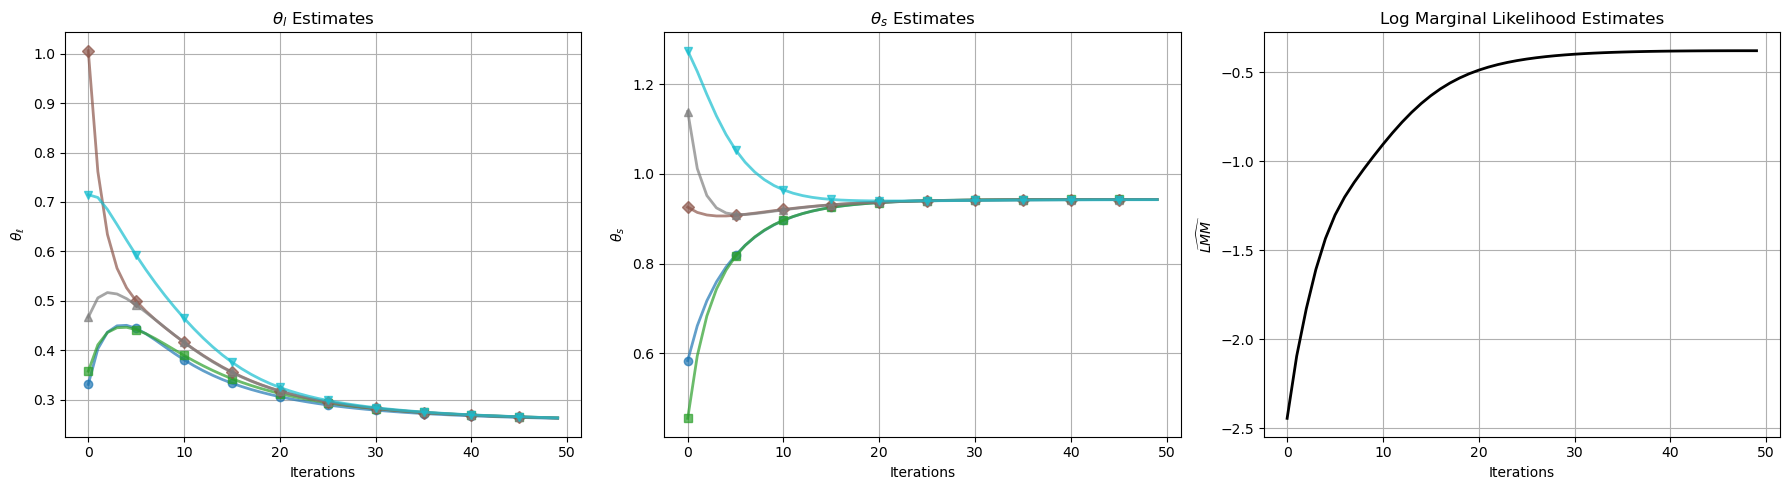

In [5]:
models, likelihoods = consensus_based_gradient(X_parts, Y_parts, G, config, Topt, eta, decay)

### Run Protocol 3


In [6]:
ntest = 200
X_test = torch.linspace(-1, 1, ntest)
means = []
variances = []

# Obtain \hat{f}_i(x) and V_i(x)
for model, likelihood in zip(models, likelihoods):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(X_test))
        means.append(pred.mean)
        variances.append(pred.variance)

In [ ]:
import time

total_time = 0.0

# Initial value
weighted_means_np = np.stack([m.numpy() / v.numpy() for m, v in zip(means, variances)])
precisions_np = np.stack([1.0 / v.numpy() for v in variances])

# Prepare tensors to store mean and variance at start and end for all test points and agents
pppoe_means_start = torch.zeros((ntest, M))
pppoe_vars_start = torch.zeros((ntest, M))
pppoe_means_end = torch.zeros((ntest, M))
pppoe_vars_end = torch.zeros((ntest, M))


start = time.perf_counter()
for i in range(ntest):
    # Prepare combined input of shape (M, 2)
    z_mean = M * weighted_means_np[:, i]    # shape (M,)
    z_prec = M * precisions_np[:, i]         # shape (M,)
    z_combined = np.stack([z_mean, z_prec], axis=1)  # shape (M, 2)

    # Run vector-valued consensus once
    consensus_history = privacy_preserving_avg_consensus(z_combined, G, config, T)  # List of (M, 2)

    idx_start = 0
    idx_end = T - 1

    # Convert to torch tensors and split
    start_vals = torch.tensor(consensus_history[idx_start])  # (M, 2)
    end_vals = torch.tensor(consensus_history[idx_end])      # (M, 2)

    mean_start = start_vals[:, 0]  # (M,)
    prec_start = start_vals[:, 1]  # (M,)
    mean_end = end_vals[:, 0]      # (M,)
    prec_end = end_vals[:, 1]      # (M,)

    # Compute final results
    pppoe_means_start[i, :] = mean_start / prec_start
    pppoe_vars_start[i, :] = 1.0 / prec_start

    pppoe_means_end[i, :] = mean_end / prec_end
    pppoe_vars_end[i, :] = 1.0 / prec_end

end = time.perf_counter()   
elapsed = (end - start) * 1000  
average = elapsed / ntest

print(f"Total elapsed time for Protocol~4: {elapsed:.0f} ms")



print(f"Average time per test point: {average:.0f} ms")


ValueError: not enough values to unpack (expected 2, got 1)

### Plot result

In [ ]:
import tikzplotlib


# Prepare true function
X_true = torch.linspace(-1, 1, ntest)
Y_true = torch.sin(2 * np.pi * X_true)

# Create subplots: Training Data | Start | End
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

titles = ['Training Data', 'Start of Consensus', 'End of Consensus']
means_list = [pppoe_means_start, pppoe_means_end]
vars_list = [pppoe_vars_start, pppoe_vars_end]

colors = plt.cm.get_cmap('tab10', M)
markers = ['o', 's', 'D', '^', 'v']

# First subplot: training data
ax = axs[0]
for agent_idx in range(M):
    train_x = X_parts[agent_idx].numpy()
    train_y = Y_parts[agent_idx].numpy()

    ax.scatter(
        train_x,
        train_y,
        color=colors(agent_idx),
        marker=markers[agent_idx % len(markers)],
        s=40,
        label=f'Agent {agent_idx + 1} Data',
        alpha=0.7,
        edgecolors='k',
        linewidth=0.5
    )

ax.set_title(titles[0], fontsize=16)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=10)
ax.set_xlim(-1, 1)

# Second and third: consensus predictions
for i in range(2):  # 0 for start, 1 for end
    ax = axs[i + 1]
    for agent_idx in range(M):
        mean_curve = means_list[i][:, agent_idx]
        std_curve = torch.sqrt(vars_list[i][:, agent_idx])

        ax.plot(
            X_true.numpy(),
            mean_curve.numpy(),
            color=colors(agent_idx),
            linestyle='-',
            linewidth=2,
            marker=markers[agent_idx % len(markers)],
            markevery=10,
            label=f'Agent {agent_idx + 1} Mean'
        )
        ax.fill_between(
            X_true.numpy(),
            (mean_curve - 2 * std_curve).numpy(),
            (mean_curve + 2 * std_curve).numpy(),
            color=colors(agent_idx),
            alpha=0.15,
        )

    ax.plot(
        X_true.numpy(),
        Y_true.numpy(),
        'k--',
        linewidth=2.5,
        label='Ground Truth'
    )

    ax.set_title(titles[i + 1], fontsize=16)
    ax.set_xlabel(r"$x$", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10)
    ax.set_xlim(-1, 1)

# Finalize layout
plt.suptitle('Agent Predictions and Training Data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Export as TikZ
tikzplotlib.save("consensus_results_plot.tex")

# Optional: show the plot in Python
plt.show()
